In [1]:
#user-defined
import ipynb.fs.full.helper as hp

#dataframes
import pandas as pd
import h5py
import datetime as dt

#math
import numpy as np
import math
import scipy.fftpack
from scipy import signal
import scipy.interpolate as interpolate
from scipy import integrate
pd.TimeSeries = pd.Series 

#gps
from geopy import distance

#plots
import pylab as plt
import matplotlib.pyplot as plt
import matplotlib.animation as animation

### Stationary Wind Bag B

In [2]:
#ubuntu
#fname='~/data/DesertDataOct/StationeryWind/20201020_172919_windy_b_data.hdf'
#mac 
fname = '~/Documents/Myfiles/DataAnalysis/data/20201020_172919_windy_b_data.hdf'
wind_df=pd.read_hdf(fname)
wind_df.keys()

Index(['millis', 'lat', 'lon', 'gps_time', 'gps_date', 'wind', 'gps_date_str',
       'year', 'month', 'day', 'gps_time_str', 'hour', 'minute', 'second',
       'time_epoch', 'S2', 'D', 'U', 'V', 'W', 'T', 'H', 'AD', 'MD'],
      dtype='object')

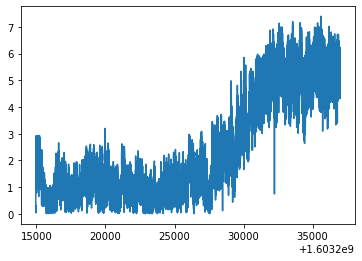

In [3]:
plt.plot(wind_df.time_epoch, wind_df.S2)

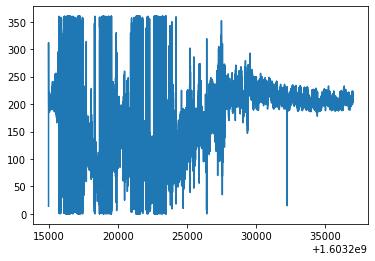

In [4]:
plt.plot(wind_df.time_epoch, wind_df.D)

In [6]:
sync_time_x = wind_df.time_epoch-wind_df.time_epoch[0]
wind_df.insert(1,'sync_time',sync_time_x)

### Extract Wind Data for shorter duration

In [19]:
df2 =pd.DataFrame
df2 = wind_df.loc[(wind_df.time_epoch >= 1603225982.1007152) & (wind_df.time_epoch <= 1603226280.795971)]

In [20]:
df2.to_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/Run03/wind05Run03.hdf', key='df2', mode='w')

/Users/an/miniconda3/envs/FlyDataAnalysis/lib/python3.8/site-packages/pandas/core/generic.py:2434: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['wind', 'gps_date_str', 'gps_time_str'], dtype='object')]

  pytables.to_hdf(


In [7]:
#interpolated wind to match the length of 300 seconds of odor bag
df2=pd.read_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/Run03/Set05/wind05Run03_Interpolated.hdf')

In [8]:
#copying to a new column->lazy step so that next steps dont need to be changed
df2['time_epoch'] = df2.master_time

In [24]:
df2.index= df2.index-df2.index[0]
sync_time0 = df2.time_epoch-df2.time_epoch[0]
#df2.insert(1,'sync_time',sync_time0)

Text(0.5, 0, 'Time (seconds)')

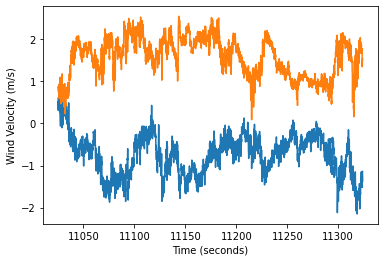

In [88]:
ff = plt.figure()
ax= ff.add_subplot(111)
ax.plot(df2.sync_time,df2.U)
ax.plot(df2.sync_time,df2.V)
ax.set_ylabel("Wind Velocity (m/s)")
ax.set_xlabel("Time (seconds)")
#plt.savefig('../figure/windspeed.jpg')

In [25]:
# integrating velocity in eastwest and northsouth to get the position for every particle at time t
posu=[]
posv=[]
for i in range(len(df2.time_epoch)):
    posu.append(integrate.cumtrapz(df2.U[i:],df2.time_epoch[i:], axis=0, initial = 0.0)) 
    posv.append(integrate.cumtrapz(df2.V[i:],df2.time_epoch[i:], axis=0, initial = 0.0))


In [90]:
# integrating TOGETHER velocity in eastwest and northsouth to get the position for every particle at time t 
positions= []
for i in range(len(df2.time_epoch)):
    positions.append(integrate.cumtrapz([df2.U[i:],df2.V[i:]], df2.time_epoch[i:], axis=1, initial =0.0))

In [91]:
positions[0] #both array 1 = X; array 2 =Y

array([[ 0.00000000e+00,  4.60012722e-02,  7.75021434e-02, ...,
        -2.23057304e+02, -2.23188808e+02, -2.23315311e+02],
       [ 0.00000000e+00,  8.45023370e-02,  1.66004591e-01, ...,
         4.71741003e+02,  4.71889007e+02,  4.72041512e+02]])

In [92]:
#x =list(zip(posu,posv))

In [10]:
#creating dataframes for each westeast particle and northsouth
westeast=pd.DataFrame(posu,columns=['particle{}'.format(x+1) for x in range(len(posu))]) #particle U
northsouth=pd.DataFrame(posv,columns=['particle{}'.format(x+1) for x in range(len(posv))]) #particle in V

NameError: name 'posu' is not defined

In [ ]:
#converting rows to columns for Position westeast
dfi = pd.DataFrame()
dfi['index']=westeast.index
westeast=westeast.T
westeast.set_index(dfi.index, inplace=True)
westeast.columns = ['particle' + str(col) for col in westeast.columns]

#adding in time from main dataframe
#westeast.insert(0, 'epoch_time', df2.time_epoch)
#westeast.insert(1, 'sync_time',df2.sync_time)

In [95]:
westeast.iloc[:,0]

0         0.000000
1         0.046001
2         0.077502
3         0.119503
4         0.163005
           ...    
2982   -222.773296
2983   -222.919300
2984   -223.057304
2985   -223.188808
2986   -223.315311
Name: particle0, Length: 2987, dtype: float64

In [96]:
delta=pd.DataFrame()
delta[0] = westeast.iloc[:,0]

In [97]:
i =2
westeast['particle'+str(i)].shift(periods=2)


0              NaN
1              NaN
2         0.000000
3         0.042001
4         0.085502
           ...    
2982   -222.850798
2983   -222.996802
2984   -223.134806
2985   -223.266310
2986   -223.392813
Name: particle2, Length: 2987, dtype: float64

In [98]:
for i in range(1,len(westeast.columns)):
    delta[i]=westeast['particle' + str(i)].shift(periods=i)


In [99]:
delta.columns = ['particle' + str(col) for col in delta.columns]
delta.fillna(0)

,particle0,particle1,particle2,particle3,particle4,particle5,particle6,particle7,particle8,particle9,...,particle2977,particle2978,particle2979,particle2980,particle2981,particle2982,particle2983,particle2984,particle2985,particle2986
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.046001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,0.077502,0.031501,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,0.119503,0.073502,0.042001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,0.163005,0.117003,0.085502,0.043501,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2982,-222.773296,-222.819297,-222.850798,-222.892799,-222.936301,-222.977802,-223.022803,-223.068304,-223.123306,-223.188307,...,-0.692519,-0.560015,-0.420011,-0.282007,-0.143004,0.000000,0.000000,0.000000,0.000000,0.0
2983,-222.919300,-222.965301,-222.996802,-223.038803,-223.082305,-223.123806,-223.168807,-223.214308,-223.269310,-223.334311,...,-0.838523,-0.706019,-0.566015,-0.428011,-0.289008,-0.146004,0.000000,0.000000,0.000000,0.0
2984,-223.057304,-223.103305,-223.134806,-223.176807,-223.220308,-223.261810,-223.306811,-223.352312,-223.407313,-223.472315,...,-0.976527,-0.844023,-0.704019,-0.566015,-0.427011,-0.284008,-0.138004,0.000000,0.000000,0.0
2985,-223.188808,-223.234809,-223.266310,-223.308311,-223.351812,-223.393313,-223.438314,-223.483816,-223.538817,-223.603819,...,-1.108030,-0.975527,-0.835523,-0.697519,-0.558515,-0.415511,-0.269507,-0.131504,0.000000,0.0


In [100]:
delta.to_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/Run03/ewdata05Run03.hdf', key='delta', mode='w')

In [101]:
#converting rows to columns for position northsouth
dfi['index1']=northsouth.index
northsouth=northsouth.T
northsouth.set_index(dfi.index1, inplace=True)
northsouth.columns = ['particle' + str(col) for col in northsouth.columns]

#adding in time from main dataframe
#northsouth.insert(0, 'epoch_time', df2.time_epoch)
#northsouth.insert(1, 'sync_time',df2.sync_time)
#northsouth

In [102]:
gamma=pd.DataFrame()
gamma[0] = northsouth.iloc[:,0]
for i in range(1,len(westeast.columns)):
    gamma[i]=northsouth['particle' + str(i)].shift(periods=i)
    
gamma.columns = ['particle' + str(col) for col in gamma.columns]
gamma.fillna(0)

,particle0,particle1,particle2,particle3,particle4,particle5,particle6,particle7,particle8,particle9,...,particle2977,particle2978,particle2979,particle2980,particle2981,particle2982,particle2983,particle2984,particle2985,particle2986
index1,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.084502,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,0.166005,0.081502,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,0.244007,0.159504,0.078002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,0.326509,0.242007,0.160504,0.082502,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2982,471.453995,471.369493,471.287991,471.209989,471.127486,471.040484,470.951481,470.868479,470.789977,470.705475,...,0.856523,0.685519,0.515514,0.343509,0.168504,0.000000,0.000000,0.000000,0.000000,0.0
2983,471.600999,471.516497,471.434995,471.356993,471.274490,471.187488,471.098486,471.015483,470.936981,470.852479,...,1.003527,0.832523,0.662518,0.490513,0.315508,0.147004,0.000000,0.000000,0.000000,0.0
2984,471.741003,471.656501,471.574999,471.496997,471.414494,471.327492,471.238489,471.155487,471.076985,470.992483,...,1.143531,0.972526,0.802522,0.630517,0.455512,0.287008,0.140004,0.000000,0.000000,0.0


In [103]:
gamma.to_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/Run03/nsdata05Run03.hdf', key='gamma', mode='w')

Text(0, 0.5, 'NorthSouth Position (m)')

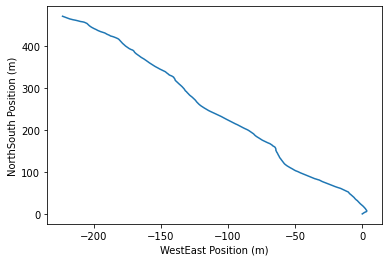

In [104]:
plt.plot(westeast.particle0,northsouth.particle0)
plt.xlabel('WestEast Position (m)')
plt.ylabel('NorthSouth Position (m)')
#plt.savefig('../figure/WindIntegratedPosition.jpg')

### Loading Bag File from the Sensor Stack with almost the same datetime

In [18]:
df= pd.read_hdf('~/Documents/Myfiles/DataAnalysis/data/Interpolated_0.h5')
time= df.master_time-df.master_time[0]
df.insert(1,'sync_time',time) 
df

,master_time,sync_time,odor,trisonica_U,trisonica_V,lat,lon
0,1.603221e+09,0.000000,0.634854,0.280000,1.160000,40.793749,-119.157556
1,1.603221e+09,0.004997,0.635494,0.289993,1.160000,40.793749,-119.157556
2,1.603221e+09,0.009995,0.635827,0.299985,1.160000,40.793749,-119.157556
3,1.603221e+09,0.014992,0.635718,0.309978,1.160000,40.793749,-119.157556
4,1.603221e+09,0.019989,0.635305,0.319970,1.160000,40.793749,-119.157556
...,...,...,...,...,...,...,...
59757,1.603221e+09,298.620872,0.591438,1.333149,-1.755375,40.793697,-119.157631
59758,1.603221e+09,298.625870,0.589259,1.496149,-1.733239,40.793697,-119.157631
59759,1.603221e+09,298.630867,0.589552,1.331477,-1.796238,40.793697,-119.157631
59760,1.603221e+09,298.635864,0.590273,1.110641,-1.873829,40.793697,-119.157631


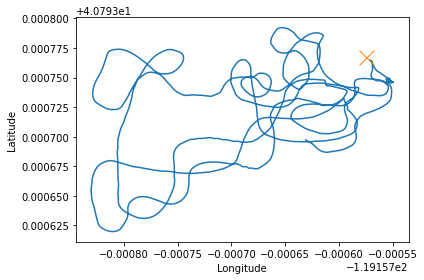

In [19]:
plt.plot(df.lon, df.lat)
plt.plot([-119.15757512132207], [40.79376709443614], marker='x', markersize=15)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.savefig('../figure/gpstrajectory.jpg')

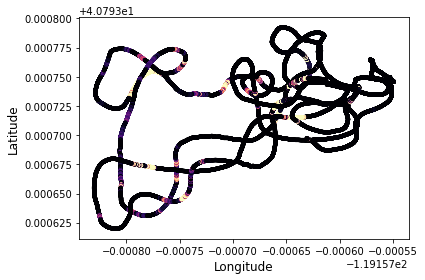

In [27]:
f= plt.figure()
ax1 = f.add_subplot(111)
ax1.scatter(df.lon, df.lat, c=df.odor, s=10, cmap='magma')
ax1.set_xlabel('Longitude', fontsize=12)
ax1.set_ylabel('Latitude', fontsize=12)
f.tight_layout()
f.savefig('../figure/odordata.jpg')

(100.0, 300.0)

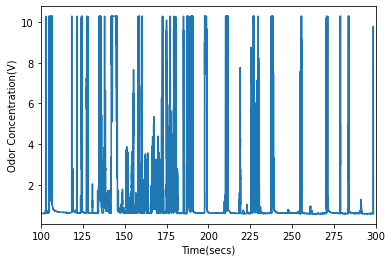

In [114]:
plt.plot(df.sync_time,df.odor)
plt.xlabel('Time(secs)')
plt.ylabel('Odor Concentration(V)')
plt.xlim(100,300)

#plt.savefig('../figure/odorconcentrationvstime.jpg')

In [98]:
query = 'odor >= 5'
df_t=df.query(query)


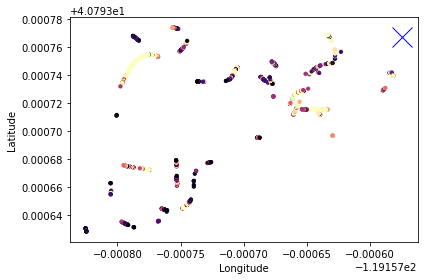

In [99]:
plt.scatter(df_t.lon, df_t.lat, c=df_t.odor, s=10, cmap='magma')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.plot([-119.15757512132207], [40.79376709443614], marker='x', markersize=20, color="b")
plt.tight_layout()
plt.savefig('../figure/odorconcentrationlocation.jpg')

In [25]:
# font = {'family' : 'normal',
#         'size'   : 16}

# plt.rc('font', **font)

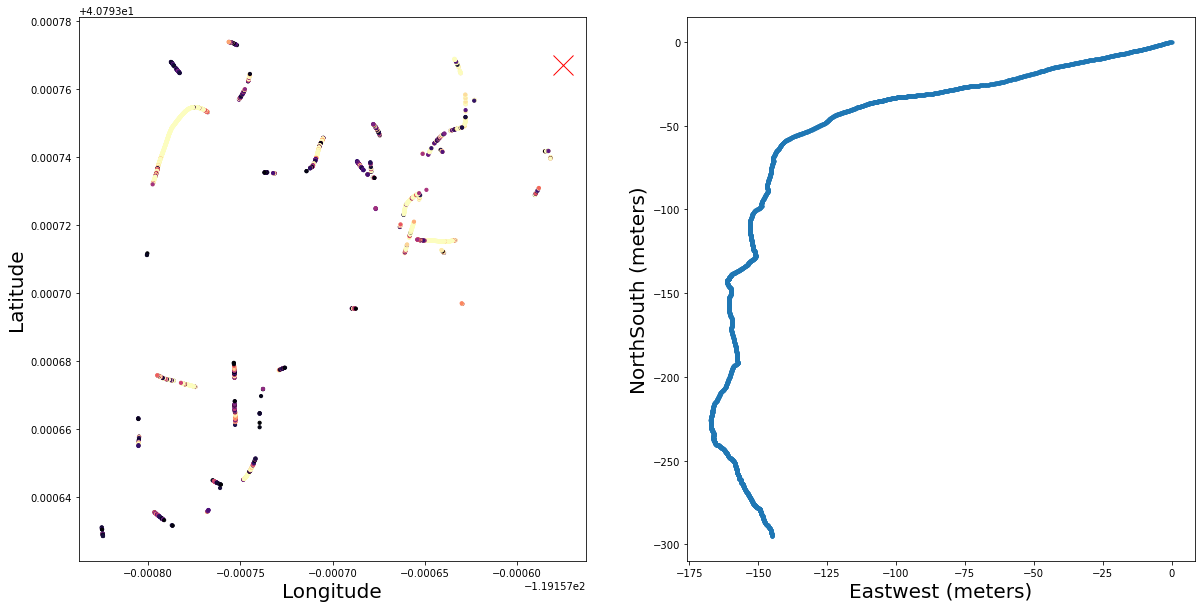

In [100]:
f, (ax1,ax2) = plt.subplots(1, 2,figsize=(20,10))
ax1.scatter(df_t.lon, df_t.lat, c=df_t.odor, s=10, cmap='magma')
ax1.set_xlabel('Longitude', fontsize=20)
ax1.set_ylabel('Latitude', fontsize=20)
ax1.plot([-119.15757512132207], [40.79376709443614], marker='x', markersize=20, color="red")
ax2.scatter(westeast.particle0,northsouth.particle0, s=10, cmap='magma')

ax2.set_xlabel('Eastwest (meters)', fontsize=20)
ax2.set_ylabel('NorthSouth (meters)', fontsize=20)
f.savefig('../figure/position_odor_comp.jpg')



### Zooming into odor and position

In [104]:
query = 'sync_time >= 150.0 and sync_time <=180.0'

In [105]:
dfodor1=df.query(query)

In [106]:
dfwe1=westeast.query(query)
dfns1=northsouth.query(query)

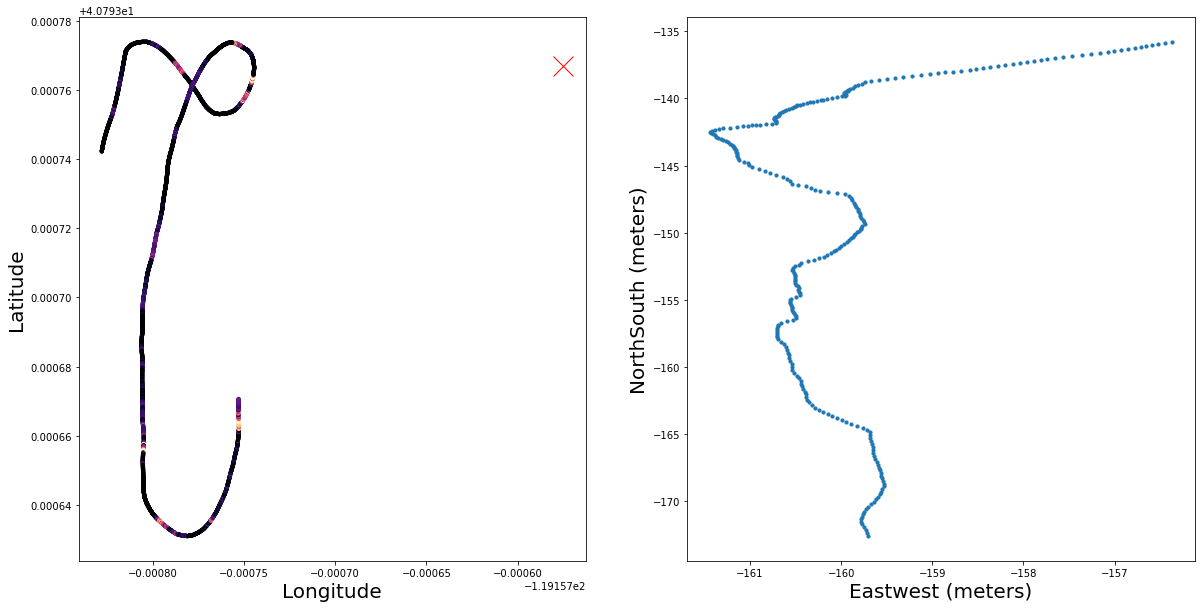

In [119]:
f0, (ax1,ax2) = plt.subplots(1, 2,figsize=(20,10))
ax1.scatter(dfodor1.lon, dfodor1.lat, c=dfodor1.odor, s=10, cmap='magma')
ax1.set_xlabel('Longitude', fontsize=20)
ax1.set_ylabel('Latitude', fontsize=20)
ax1.plot([-119.15757512132207], [40.79376709443614], marker='x', markersize=20, color="red")
ax2.scatter(dfwe1.particle0,dfns1.particle0, s=10, cmap='magma')

ax2.set_xlabel('Eastwest (meters)', fontsize=20)
ax2.set_ylabel('NorthSouth (meters)', fontsize=20)
#f0.savefig('../figure/position_odor_zoom1.jpg')

In [112]:
query1 = 'sync_time >= 175.0 and sync_time <=225.0'
dfodor2=df.query(query1)
dfwe2=westeast.query(query1)
dfns2=northsouth.query(query1)

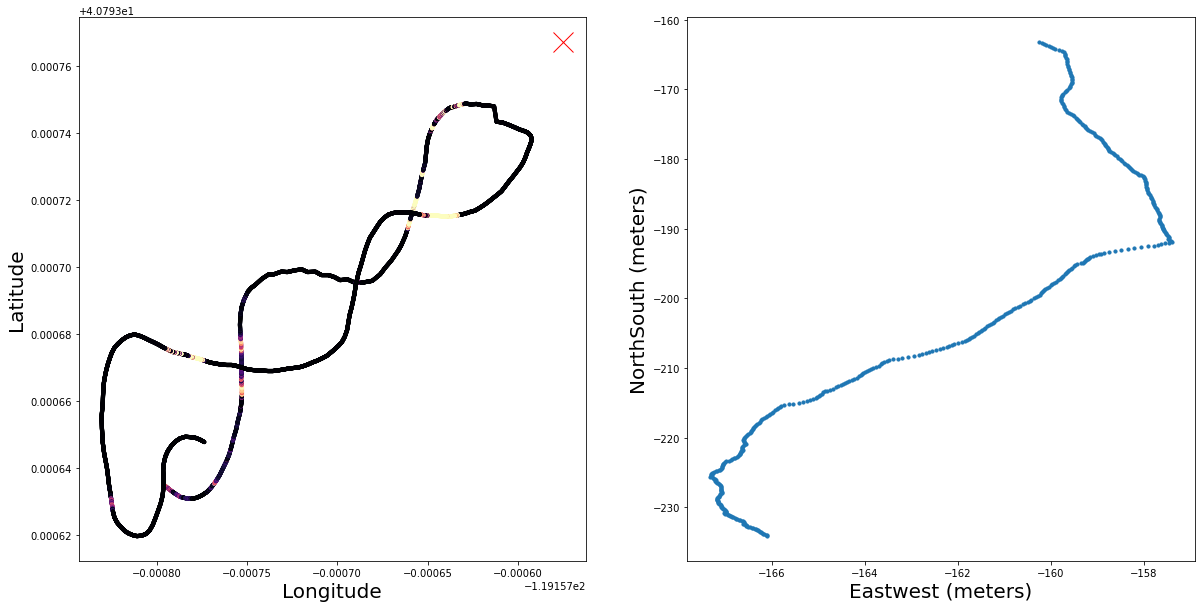

In [120]:
f1, (ax1,ax2) = plt.subplots(1, 2,figsize=(20,10))
ax1.scatter(dfodor2.lon, dfodor2.lat, c=dfodor2.odor, s=10, cmap='magma')
ax1.set_xlabel('Longitude', fontsize=20)
ax1.set_ylabel('Latitude', fontsize=20)
ax1.plot([-119.15757512132207], [40.79376709443614], marker='x', markersize=20, color="red")
ax2.scatter(dfwe2.particle0,dfns2.particle0, s=10, cmap='magma')

ax2.set_xlabel('Eastwest (meters)', fontsize=20)
ax2.set_ylabel('NorthSouth (meters)', fontsize=20)
#f1.savefig('../figure/position_odor_zoom2.jpg')

In [115]:
query2 = 'sync_time >= 100.0 and sync_time <=150.0'
dfodor3=df.query(query2)
dfwe3=westeast.query(query2)
dfns3=northsouth.query(query2)

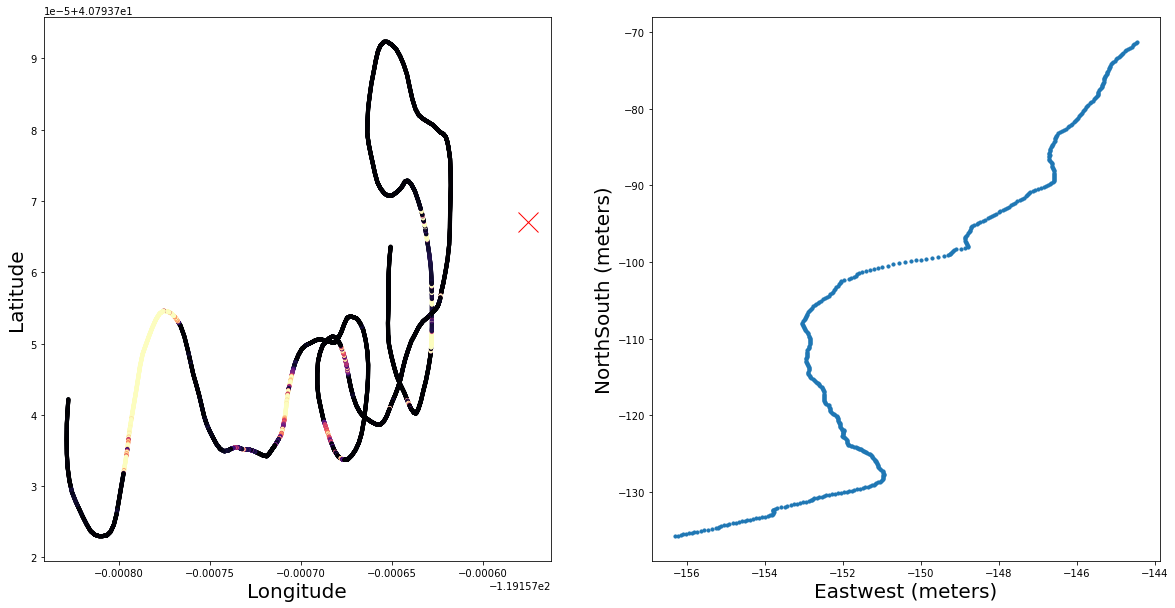

In [121]:
f2, (ax1,ax2) = plt.subplots(1, 2,figsize=(20,10))
ax1.scatter(dfodor3.lon, dfodor3.lat, c=dfodor3.odor, s=10, cmap='magma')
ax1.set_xlabel('Longitude', fontsize=20)
ax1.set_ylabel('Latitude', fontsize=20)
ax1.plot([-119.15757512132207], [40.79376709443614], marker='x', markersize=20, color="red")
ax2.scatter(dfwe3.particle0,dfns3.particle0, s=10, cmap='magma')

ax2.set_xlabel('Eastwest (meters)', fontsize=20)
ax2.set_ylabel('NorthSouth (meters)', fontsize=20)
#f2.savefig('../figure/position_odor_zoom3.jpg')

### Setup Bags - BAG01 - Source Location

In [ ]:
# #dfbag01 = hp.import_csv("~/data/DesertDataOct/Run01/OctoberRun01Bag01.csv") 
# dfbag01 = hp.import_csv("~/data/DesertDataOct/Run01/OctoberRun01Bag01.csv")

In [ ]:
# epoch_setup(dfbag01)

In [ ]:
# dfbag01=dfbag01.interpolate()

In [ ]:
# # dfbag01.keys()
# fig = plt.figure()

# ax = fig.add_subplot(111)

# ax.plot(dfbag01._ublox_gps_fix_longitude, dfbag01._ublox_gps_fix_latitude)
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')

In [ ]:
# plt.plot(dfbag01.sync_time,dfbag01._ublox_gps_fix_latitude)

In [ ]:
# query = 'sync_time > 75 and sync_time < 150'
# df_gps= dfbag01.query(query)

In [ ]:
# source_location_lat=df_gps._ublox_gps_fix_latitude.mean()
# source_location_long=df_gps._ublox_gps_fix_longitude.mean()
# source_location=[source_location_lat, source_location_long]
# source_location

# query = '_analog_output_data > 5 and _analog_output_data <= 10'
# df_tmp = dfbag01.query(query)

# fig_odor_gps = plt.figure()
# ax_odor_gps_filtered = fig_odor_gps.add_subplot(111)
# ax_odor_gps_filtered.scatter(df_tmp._ublox_gps_fix_latitude, df_tmp._ublox_gps_fix_longitude, c=df_tmp._ublox_gps_fix_altitude, s=10, cmap='magma')
# ax_odor_gps_filtered.set_xlabel('Latitude')
# ax_odor_gps_filtered.set_ylabel('Longitude')

# plt.plot([40.79376709443614], [-119.15757512132207], marker='x', markersize=20, color="black")